### Tải các thư viện cần thiết

In [1]:
%%capture
!pip install neuralforecast

In [2]:
%%capture
!pip install pytorch_lightning

In [3]:
%%capture
!pip install hyperopt

### Import các thư viện cần thiết

In [4]:
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

from neuralforecast import NeuralForecast
from neuralforecast.models import NHITS
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss, PMM, GMM, NBMM
from neuralforecast.tsdataset import TimeSeriesDataset

### 1.Áp dụng mô hình để dự đoán cho dữ liệu về giá vàng

In [5]:
# Tải dữ liệu từ dataset
df_gold = pd.read_csv('/content/sample_data/gold_price_2018_2024.csv')

df_gold.index += 1

In [6]:
df_gold.head()

Date  Value (USD per troy ounce)
1  2018-01-01                 1307.018690
2  2018-01-02                 1319.827953
3  2018-01-03                 1311.501862
4  2018-01-04                 1321.635371
5  2018-01-05                 1319.589185

In [7]:
# Chuyển đổi kiểu dữ liệu
df_gold['Date'] = pd.to_datetime(df_gold['Date'])
df_gold.columns= ['Date', 'Price']
# Xoá dữ liệu bị null
df_gold = df_gold.dropna()

# Gán lại tên cột cho dữ liệu
df_gold.rename(columns={'Date': 'ds', 'Price': 'y'}, inplace=True)

# Thêm thuộc tính mới unique_id để thoả mãn điều kiện các cột của mô hình N-hits
df_gold['unique_id'] = 'TAR'
df_gold

ds            y unique_id
1    2018-01-01  1307.018690       TAR
2    2018-01-02  1319.827953       TAR
3    2018-01-03  1311.501862       TAR
4    2018-01-04  1321.635371       TAR
5    2018-01-05  1319.589185       TAR
...         ...          ...       ...
2248 2024-02-26  2031.609404       TAR
2249 2024-02-27  2033.313814       TAR
2250 2024-02-28  2032.653770       TAR
2251 2024-02-29  2036.199141       TAR
2252 2024-03-01  2044.591310       TAR

[2252 rows x 3 columns]

#### 1.1 Tỉ lệ train 9:1

##### Vẽ biểu đồ

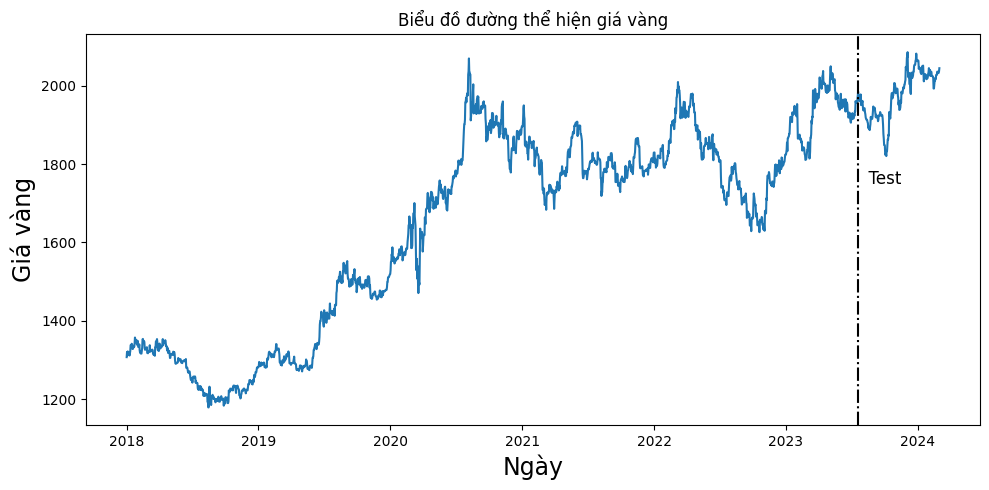

In [8]:
x_plot = pd.to_datetime(df_gold.ds)
y_plot = df_gold.y.values

x_value = x_plot[2026]

fig = plt.figure(figsize=(10, 5))
fig.tight_layout()

plt.plot(x_plot, y_plot)
plt.title('Biểu đồ đường thể hiện giá vàng')
plt.xlabel('Ngày', fontsize=17)
plt.ylabel('Giá vàng', fontsize=17)

plt.axvline(x_value, color='black', linestyle='-.')
plt.text(x_value, 1750, '  Test', fontsize=12)

plt.tight_layout()
plt.show()
plt.close()

##### Dùng N-hits để dự đoán giá vàng

In [9]:
train_df = df_gold.iloc[:2026].reset_index(drop=True)
test_df = df_gold.iloc[2026:].reset_index(drop=True)

# Tạo model
model = NHITS(
    h=len(test_df),
    input_size=(len(test_df) * 2),
    loss=DistributionLoss(distribution='StudentT', level=[80, 90], return_params=True),
    stat_exog_list=[],
    futr_exog_list=[],
    n_freq_downsample=[2, 1, 1],
    scaler_type='robust',
    max_steps=2000,
    inference_windows_batch_size=32,
    learning_rate=1e-4
)

# Huấn luyện và dự đoán
fcst = NeuralForecast(models=[model], freq='D')
fcst.fit(df=train_df)
forecasts = fcst.predict(futr_df=test_df)

# Plotting
Y_hat_df = forecasts.reset_index(drop=False).drop(columns=['unique_id', 'ds'])
plot_df = pd.concat([test_df, Y_hat_df], axis=1)
plot_df = pd.concat([train_df, plot_df])

plot_df = plot_df[plot_df.unique_id=='TAR'].drop('unique_id', axis=1)
plt.plot(train_df['ds'], train_df['y'], color='green', label='Training Price')
plt.plot(test_df['ds'], test_df['y'], c='red', label='Actual Price')
plt.plot(plot_df['ds'], plot_df['NHITS'], c='blue', label='Predicted Price')
plt.xlabel('Ngày')
plt.ylabel('Giá vàng')
plt.title('Dự đoán giá vàng với N-hits')
plt.legend()
plt.grid()
plt.show()


INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type             | Params
--------------------------------------------------
0 | loss         | DistributionLoss | 5     
1 | padder_train | ConstantPad1d    | 0     
2 | scaler       | TemporalNorm     | 0     
3 | blocks       | ModuleList       | 4.4 M 
--------------------------------------------------
4.4 M     Trainable params
5         Non-trainable params
4.4 M     Total params
17.574    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=2000` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


##### Đánh giá mô hình

In [10]:
# Đánh giá mô hình với dữ liệu giá vàng
actual_gold = test_df['y'].values
predict_gold = Y_hat_df['NHITS'].values

rmse_gold = np.sqrt(mean_squared_error(actual_gold, predict_gold))
mape_gold = np.mean(np.abs((actual_gold - predict_gold) / actual_gold)) * 100
mae_gold = mean_absolute_error(actual_gold, predict_gold)

print(f'RMSE: {rmse_gold}')
print(f'MAPE: {mape_gold}%')
print(f'MAE: {mae_gold}')

RMSE: 153.02129679977946
MAPE: 6.814825064227668%
MAE: 133.42492142899613


#### 1.1 Tỉ lệ train 8:2

##### Vẽ biểu đồ

In [11]:
x_plot = pd.to_datetime(df_gold.ds)
y_plot = df_gold.y.values

x_value = x_plot[1800]

fig = plt.figure(figsize=(10, 5))
fig.tight_layout()

plt.plot(x_plot, y_plot)
plt.title('Biểu đồ đường thể hiện giá vàng')
plt.xlabel('Ngày', fontsize=17)
plt.ylabel('Giá vàng', fontsize=17)

plt.axvline(x_value, color='black', linestyle='-.')
plt.text(x_value, 1750, '  Test', fontsize=12)

plt.tight_layout()
plt.show()
plt.close()

##### Dùng N-hits để dự đoán giá vàng

In [12]:
train_df = df_gold.iloc[:1800].reset_index(drop=True)
test_df = df_gold.iloc[1800:].reset_index(drop=True)

# Khai báo model
model = NHITS(
    h=len(test_df),
    input_size=(len(test_df) * 2),
    loss=DistributionLoss(distribution='StudentT', level=[80, 90], return_params=True),
    stat_exog_list=[],
    futr_exog_list=[],
    n_freq_downsample=[2, 1, 1],
    scaler_type='robust',
    max_steps=2000,
    inference_windows_batch_size=32,
    learning_rate=1e-4
)

# Huấn luyện và dự đoán
fcst = NeuralForecast(models=[model], freq='D')
fcst.fit(df=train_df)
forecasts = fcst.predict(futr_df=test_df)

# Plotting
Y_hat_df = forecasts.reset_index(drop=False).drop(columns=['unique_id', 'ds'])
plot_df = pd.concat([test_df, Y_hat_df], axis=1)
plot_df = pd.concat([train_df, plot_df])

plot_df = plot_df[plot_df.unique_id=='TAR'].drop('unique_id', axis=1)
plt.plot(train_df['ds'], train_df['y'], color='green', label='Training Price')
plt.plot(test_df['ds'], test_df['y'], c='red', label='Actual Price')
plt.plot(plot_df['ds'], plot_df['NHITS'], c='blue', label='Predicted Price')

plt.xlabel('Ngày')
plt.ylabel('Giá vàng')
plt.title('Dự đoán giá vàng với N-hits')
plt.legend()
plt.grid()
plt.show()


INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type             | Params
--------------------------------------------------
0 | loss         | DistributionLoss | 5     
1 | padder_train | ConstantPad1d    | 0     
2 | scaler       | TemporalNorm     | 0     
3 | blocks       | ModuleList       | 6.4 M 
--------------------------------------------------
6.4 M     Trainable params
5         Non-trainable params
6.4 M     Total params
25.686    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=2000` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


##### Đánh giá mô hình

In [13]:
# Đánh giá mô hình với dữ liệu giá vàng
actual_gold = test_df['y'].values
predict_gold = Y_hat_df['NHITS'].values

rmse_gold = np.sqrt(mean_squared_error(actual_gold, predict_gold))
mape_gold = np.mean(np.abs((actual_gold - predict_gold) / actual_gold)) * 100
mae_gold = mean_absolute_error(actual_gold, predict_gold)

print(f'RMSE: {rmse_gold}')
print(f'MAPE: {mape_gold}%')
print(f'MAE: {mae_gold}')

RMSE: 182.30673212304106
MAPE: 8.177242922414582%
MAE: 161.88497126202992


#### 1.1 Tỉ lệ train 7:3

##### Vẽ biểu đồ

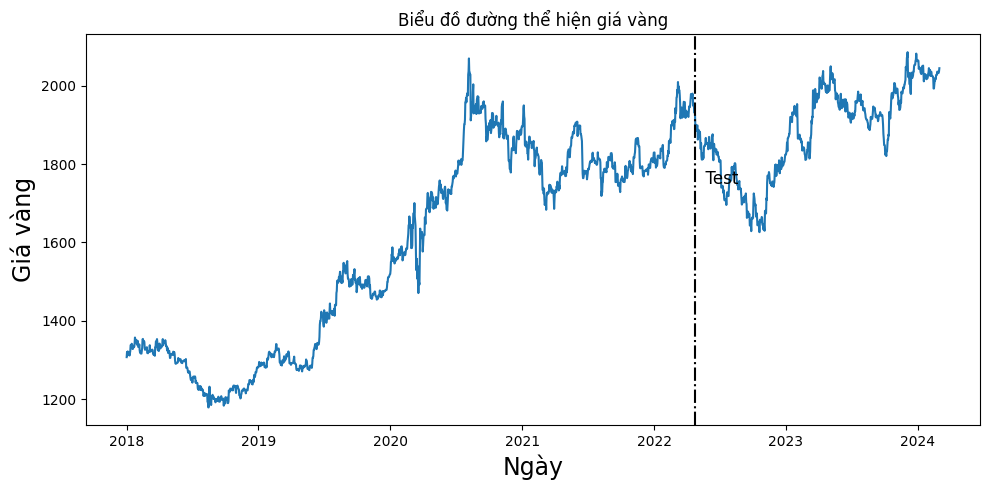

In [14]:
x_plot = pd.to_datetime(df_gold.ds)
y_plot = df_gold.y.values

x_value = x_plot[1576]

fig = plt.figure(figsize=(10, 5))
fig.tight_layout()

plt.plot(x_plot, y_plot)
plt.title('Biểu đồ đường thể hiện giá vàng')
plt.xlabel('Ngày', fontsize=17)
plt.ylabel('Giá vàng', fontsize=17)

plt.axvline(x_value, color='black', linestyle='-.')
plt.text(x_value, 1750, '  Test', fontsize=12)

plt.tight_layout()
plt.show()
plt.close()

##### Dùng N-hits để dự đoán giá vàng

In [15]:
train_df = df_gold.iloc[:1576].reset_index(drop=True)
test_df = df_gold.iloc[1576:].reset_index(drop=True)

# Tạo model
model = NHITS(
    h=len(test_df),
    input_size=(len(test_df) * 2),
    loss=DistributionLoss(distribution='StudentT', level=[80, 90], return_params=True),
    stat_exog_list=[],
    futr_exog_list=[],
    n_freq_downsample=[2, 1, 1],
    scaler_type='robust',
    max_steps=2000,
    inference_windows_batch_size=32,
    learning_rate=1e-4
)

# Huấn luyện và dự đoán
fcst = NeuralForecast(models=[model], freq='D')
fcst.fit(df=train_df)
forecasts = fcst.predict(futr_df=test_df)

# Plotting
Y_hat_df = forecasts.reset_index(drop=False).drop(columns=['unique_id', 'ds'])
plot_df = pd.concat([test_df, Y_hat_df], axis=1)
plot_df = pd.concat([train_df, plot_df])

plot_df = plot_df[plot_df.unique_id=='TAR'].drop('unique_id', axis=1)
plt.plot(train_df['ds'], train_df['y'], color='green', label='Training Price')
plt.plot(test_df['ds'], test_df['y'], c='red', label='Actual Price')
plt.plot(plot_df['ds'], plot_df['NHITS'], c='blue', label='Predicted Price')
plt.xlabel('Ngày')
plt.ylabel('Giá vàng')
plt.title('Dự đoán giá vàng với N-hits')
plt.legend()
plt.grid()
plt.show()


INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type             | Params
--------------------------------------------------
0 | loss         | DistributionLoss | 5     
1 | padder_train | ConstantPad1d    | 0     
2 | scaler       | TemporalNorm     | 0     
3 | blocks       | ModuleList       | 8.4 M 
--------------------------------------------------
8.4 M     Trainable params
5         Non-trainable params
8.4 M     Total params
33.726    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=2000` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


##### Đánh giá mô hình

In [16]:
# Đánh giá mô hình với dữ liệu giá vàng
actual_gold = test_df['y'].values
predict_gold = Y_hat_df['NHITS'].values

rmse_gold = np.sqrt(mean_squared_error(actual_gold, predict_gold))
mape_gold = np.mean(np.abs((actual_gold - predict_gold) / actual_gold)) * 100
mae_gold = mean_absolute_error(actual_gold, predict_gold)

print(f'RMSE: {rmse_gold}')
print(f'MAPE: {mape_gold}%')
print(f'MAE: {mae_gold}')

RMSE: 182.79057807281836
MAPE: 7.951570349139864%
MAE: 148.08549773371624


### 2.Áp dụng mô hình để dự đoán cho dữ liệu về giá bạc

In [17]:
# Tải dữ liệu từ dataset
df_silver = pd.read_csv('/content/sample_data/silver_price_2018_2024.csv')

df_silver.index += 1

In [18]:
df_silver.head()

Date  Value (USD per troy ounce)
1  1/1/2018                   16.993771
2  1/2/2018                   17.196475
3  1/3/2018                   17.112426
4  1/4/2018                   17.200338
5  1/5/2018                   17.220985

In [19]:
# Chuyển đổi kiểu dữ liệu
df_silver['Date'] = pd.to_datetime(df_silver['Date'])
df_silver.columns= ['Date', 'Price']
# Xoá dữ liệu bị null
df_silver = df_silver.dropna()

# Gán lại tên cột cho dữ liệu
df_silver.rename(columns={'Date': 'ds', 'Price': 'y'}, inplace=True)

# Thêm thuộc tính mới unique_id để thoả mãn điều kiện các cột của mô hình N-hits
df_silver['unique_id'] = 'TAR'

df_silver

ds          y unique_id
1    2018-01-01  16.993771       TAR
2    2018-01-02  17.196475       TAR
3    2018-01-03  17.112426       TAR
4    2018-01-04  17.200338       TAR
5    2018-01-05  17.220985       TAR
...         ...        ...       ...
2248 2024-02-26  22.800718       TAR
2249 2024-02-27  22.558054       TAR
2250 2024-02-28  22.486938       TAR
2251 2024-02-29  22.507808       TAR
2252 2024-03-01  22.676529       TAR

[2252 rows x 3 columns]

#### 1.1 Tỉ lệ train 9:1

##### Vẽ biểu đồ

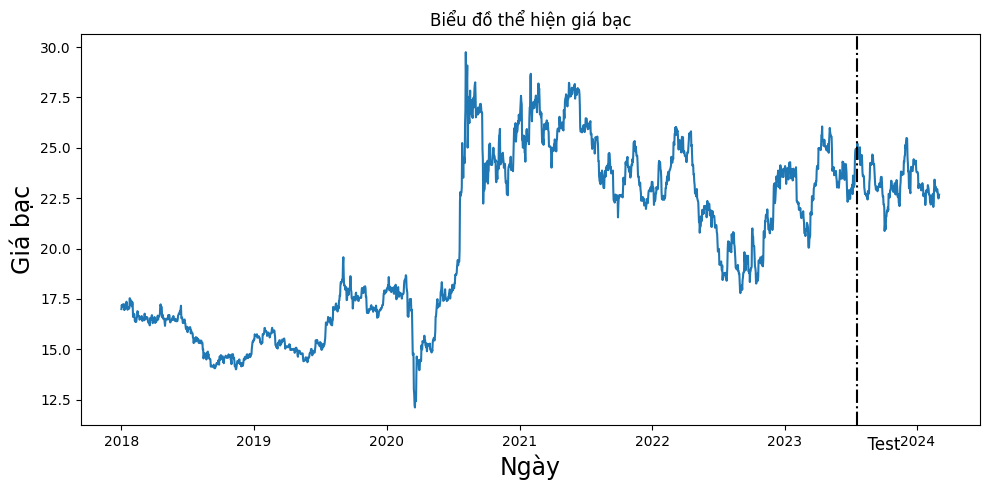

In [20]:
x_plot = pd.to_datetime(df_silver.ds)
y_plot = df_silver.y.values

x_value = x_plot[2026]

fig = plt.figure(figsize=(10, 5))
fig.tight_layout()

plt.plot(x_plot, y_plot)
plt.title('Biểu đồ thể hiện giá bạc')
plt.xlabel('Ngày', fontsize=17)
plt.ylabel('Giá bạc', fontsize=17)

plt.axvline(x_value, color='black', linestyle='-.')
plt.text(x_value, 10, '  Test', fontsize=12)

plt.tight_layout()
plt.show()
plt.close()

##### Dùng N-hits để dự đoán giá bạc

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type             | Params
--------------------------------------------------
0 | loss         | DistributionLoss | 5     
1 | padder_train | ConstantPad1d    | 0     
2 | scaler       | TemporalNorm     | 0     
3 | blocks       | ModuleList       | 4.4 M 
--------------------------------------------------
4.4 M     Trainable params
5         Non-trainable params
4.4 M     Total params
17.574    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=2000` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


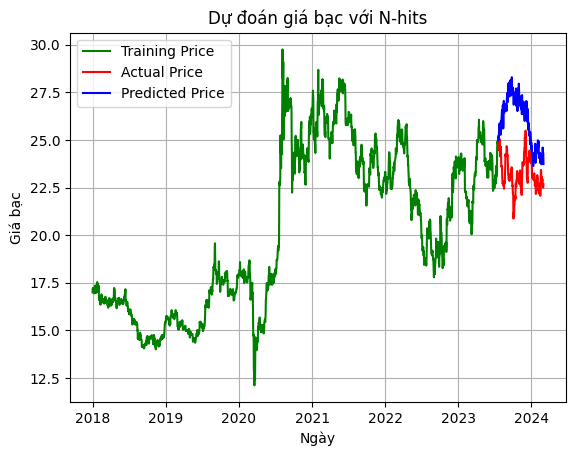

In [21]:
train_df = df_silver.iloc[:2026].reset_index(drop=True)
test_df = df_silver.iloc[2026:].reset_index(drop=True)

# Tạo model
model = NHITS(
    h=len(test_df),
    input_size=(len(test_df) * 2),
    loss=DistributionLoss(distribution='StudentT', level=[80, 90], return_params=True),
    stat_exog_list=[],
    futr_exog_list=[],
    n_freq_downsample=[2, 1, 1],
    scaler_type='robust',
    max_steps=2000,
    inference_windows_batch_size=32,
    learning_rate=1e-4
)

# Huấn luyện và dự đoán
fcst = NeuralForecast(models=[model], freq='D')
fcst.fit(df=train_df)
forecasts = fcst.predict(futr_df=test_df)

# Plotting
Y_hat_df = forecasts.reset_index(drop=False).drop(columns=['unique_id', 'ds'])
plot_df = pd.concat([test_df, Y_hat_df], axis=1)
plot_df = pd.concat([train_df, plot_df])

plot_df = plot_df[plot_df.unique_id=='TAR'].drop('unique_id', axis=1)
plt.plot(train_df['ds'], train_df['y'], color='green', label='Training Price')
plt.plot(test_df['ds'], test_df['y'], c='red', label='Actual Price')
plt.plot(plot_df['ds'], plot_df['NHITS'], c='blue', label='Predicted Price')
plt.xlabel('Ngày')
plt.ylabel('Giá bạc')
plt.title('Dự đoán giá bạc với N-hits')
plt.legend()
plt.grid()
plt.show()


##### Đánh giá mô hình

In [22]:
# Đánh giá mô hình với dữ liệu giá bạc
actual_silver = test_df['y'].values
predict_silver = Y_hat_df['NHITS'].values

rmse_silver = np.sqrt(mean_squared_error(actual_silver, predict_silver))
mape_silver = np.mean(np.abs((actual_silver - predict_silver) / actual_silver)) * 100
mae_silver = mean_absolute_error(actual_silver, predict_silver)

print(f'RMSE: {rmse_silver}')
print(f'MAPE: {mape_silver}%')
print(f'MAE: {mae_silver}')

RMSE: 3.178123763450625
MAPE: 12.113639300896208%
MAE: 2.7835048283863815


#### 1.1 Tỉ lệ train 8:2

##### Vẽ biểu đồ

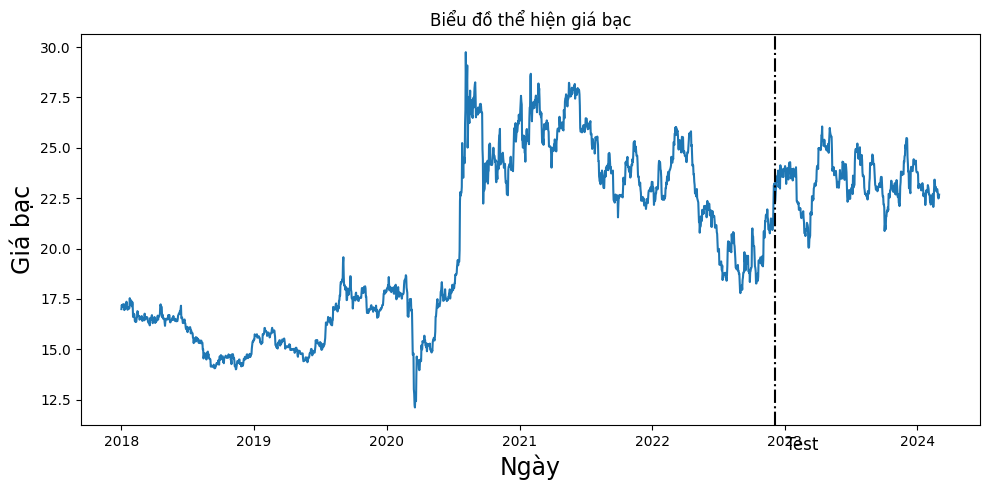

In [23]:
x_plot = pd.to_datetime(df_silver.ds)
y_plot = df_silver.y.values

x_value = x_plot[1800]

fig = plt.figure(figsize=(10, 5))
fig.tight_layout()

plt.plot(x_plot, y_plot)
plt.title('Biểu đồ thể hiện giá bạc')
plt.xlabel('Ngày', fontsize=17)
plt.ylabel('Giá bạc', fontsize=17)

plt.axvline(x_value, color='black', linestyle='-.')
plt.text(x_value, 10, '  Test', fontsize=12)

plt.tight_layout()
plt.show()
plt.close()

##### Dùng N-hits để dự đoán giá bạc

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type             | Params
--------------------------------------------------
0 | loss         | DistributionLoss | 5     
1 | padder_train | ConstantPad1d    | 0     
2 | scaler       | TemporalNorm     | 0     
3 | blocks       | ModuleList       | 6.4 M 
--------------------------------------------------
6.4 M     Trainable params
5         Non-trainable params
6.4 M     Total params
25.686    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=2000` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


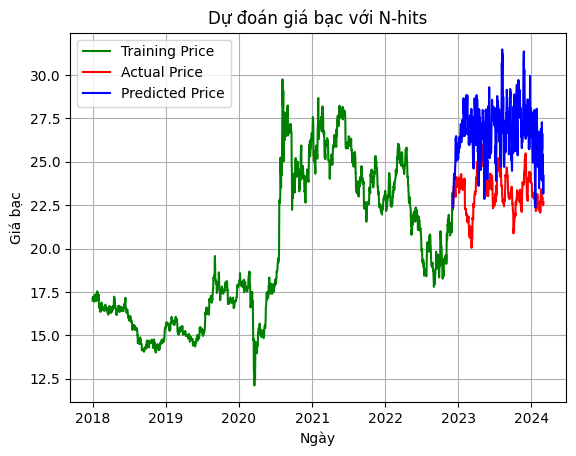

In [24]:
train_df = df_silver.iloc[:1800].reset_index(drop=True)
test_df = df_silver.iloc[1800:].reset_index(drop=True)

# Khai báo model
model = NHITS(
    h=len(test_df),
    input_size=(len(test_df) * 2),
    loss=DistributionLoss(distribution='StudentT', level=[80, 90], return_params=True),
    stat_exog_list=[],
    futr_exog_list=[],
    n_freq_downsample=[2, 1, 1],
    scaler_type='robust',
    max_steps=2000,
    inference_windows_batch_size=32,
    learning_rate=1e-4
)

# Huấn luyện và dự đoán
fcst = NeuralForecast(models=[model], freq='D')
fcst.fit(df=train_df)
forecasts = fcst.predict(futr_df=test_df)

# Plotting
Y_hat_df = forecasts.reset_index(drop=False).drop(columns=['unique_id', 'ds'])
plot_df = pd.concat([test_df, Y_hat_df], axis=1)
plot_df = pd.concat([train_df, plot_df])

plot_df = plot_df[plot_df.unique_id=='TAR'].drop('unique_id', axis=1)
plt.plot(train_df['ds'], train_df['y'], color='green', label='Training Price')
plt.plot(test_df['ds'], test_df['y'], c='red', label='Actual Price')
plt.plot(plot_df['ds'], plot_df['NHITS'], c='blue', label='Predicted Price')

plt.xlabel('Ngày')
plt.ylabel('Giá bạc')
plt.title('Dự đoán giá bạc với N-hits')
plt.legend()
plt.grid()
plt.show()


##### Đánh giá mô hình

In [25]:
# Đánh giá mô hình với dữ liệu giá bạc
actual_silver = test_df['y'].values
predict_silver = Y_hat_df['NHITS'].values

rmse_silver = np.sqrt(mean_squared_error(actual_silver, predict_silver))
mape_silver = np.mean(np.abs((actual_silver - predict_silver) / actual_silver)) * 100
mae_silver = mean_absolute_error(actual_silver, predict_silver)

print(f'RMSE: {rmse_silver}')
print(f'MAPE: {mape_silver}%')
print(f'MAE: {mae_silver}')

RMSE: 3.8789531125376344
MAPE: 15.055695085853316%
MAE: 3.4607420305047984


#### 1.1 Tỉ lệ train 7:3

##### Vẽ biểu đồ

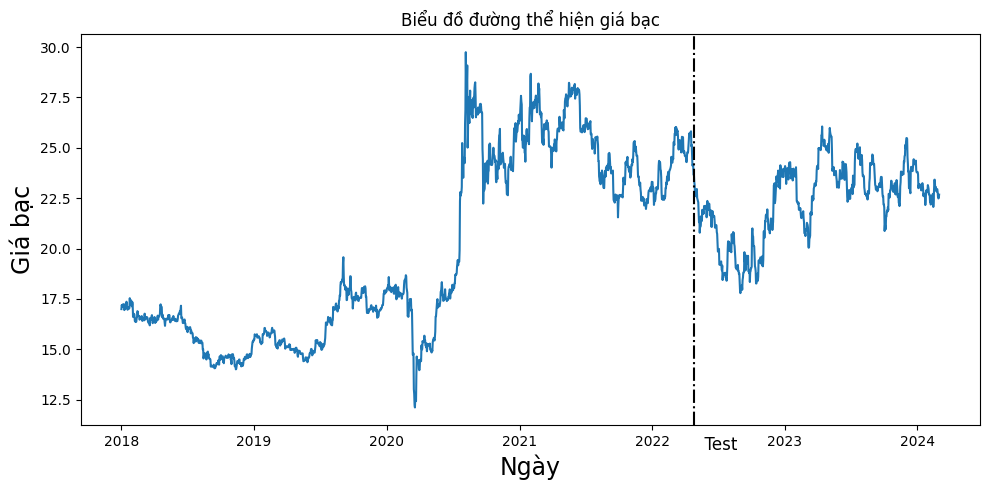

In [26]:
x_plot = pd.to_datetime(df_silver.ds)
y_plot = df_silver.y.values

x_value = x_plot[1576]

fig = plt.figure(figsize=(10, 5))
fig.tight_layout()

plt.plot(x_plot, y_plot)
plt.title('Biểu đồ đường thể hiện giá bạc')
plt.xlabel('Ngày', fontsize=17)
plt.ylabel('Giá bạc', fontsize=17)

plt.axvline(x_value, color='black', linestyle='-.')
plt.text(x_value, 10, '  Test', fontsize=12)

plt.tight_layout()
plt.show()
plt.close()

##### Dùng N-hits để dự đoán giá bạc

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type             | Params
--------------------------------------------------
0 | loss         | DistributionLoss | 5     
1 | padder_train | ConstantPad1d    | 0     
2 | scaler       | TemporalNorm     | 0     
3 | blocks       | ModuleList       | 8.4 M 
--------------------------------------------------
8.4 M     Trainable params
5         Non-trainable params
8.4 M     Total params
33.726    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=2000` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


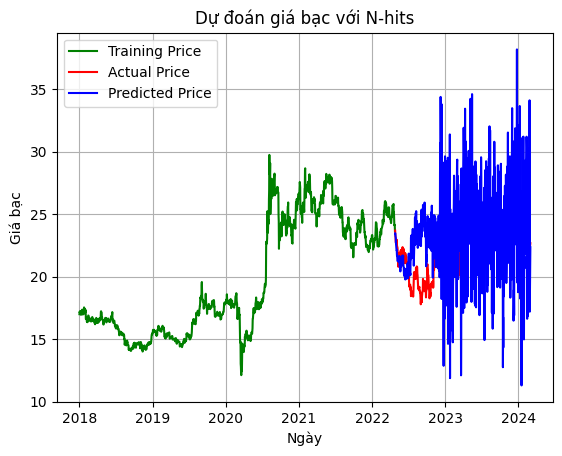

In [27]:
train_df = df_silver.iloc[:1576].reset_index(drop=True)
test_df = df_silver.iloc[1576:].reset_index(drop=True)

# Tạo model
model = NHITS(
    h=len(test_df),
    input_size=(len(test_df) * 2),
    loss=DistributionLoss(distribution='StudentT', level=[80, 90], return_params=True),
    stat_exog_list=[],
    futr_exog_list=[],
    n_freq_downsample=[2, 1, 1],
    scaler_type='robust',
    max_steps=2000,
    inference_windows_batch_size=32,
    learning_rate=1e-4
)

# Huấn luyện và dự đoán
fcst = NeuralForecast(models=[model], freq='D')
fcst.fit(df=train_df)
forecasts = fcst.predict(futr_df=test_df)

# Plotting
Y_hat_df = forecasts.reset_index(drop=False).drop(columns=['unique_id', 'ds'])
plot_df = pd.concat([test_df, Y_hat_df], axis=1)
plot_df = pd.concat([train_df, plot_df])

plot_df = plot_df[plot_df.unique_id=='TAR'].drop('unique_id', axis=1)
plt.plot(train_df['ds'], train_df['y'], color='green', label='Training Price')
plt.plot(test_df['ds'], test_df['y'], c='red', label='Actual Price')
plt.plot(plot_df['ds'], plot_df['NHITS'], c='blue', label='Predicted Price')
plt.xlabel('Ngày')
plt.ylabel('Giá bạc')
plt.title('Dự đoán giá bạc với N-hits')
plt.legend()
plt.grid()
plt.show()


##### Đánh giá mô hình

In [28]:
# Đánh giá mô hình với dữ liệu giá bạc
actual_silver = test_df['y'].values
predict_silver = Y_hat_df['NHITS'].values

rmse_silver = np.sqrt(mean_squared_error(actual_silver, predict_silver))
mape_silver = np.mean(np.abs((actual_silver - predict_silver) / actual_silver)) * 100
mae_silver = mean_absolute_error(actual_silver, predict_silver)

print(f'RMSE: {rmse_silver}')
print(f'MAPE: {mape_silver}%')
print(f'MAE: {mae_silver}')

RMSE: 3.9724031801573507
MAPE: 14.290229537467217%
MAE: 3.159392008305711


### 3.Áp dụng mô hình để dự đoán cho dữ liệu về giá bạch kim

In [29]:
# Tải dữ liệu từ dataset
df_platium = pd.read_csv('/content/sample_data/platium_price_2018_2024.csv')

df_platium.index += 1

In [30]:
df_platium.head()

Date  Value (USD per troy ounce)
1  2018-01-01                  930.030587
2  2018-01-02                  944.375754
3  2018-01-03                  954.910273
4  2018-01-04                  960.864535
5  2018-01-05                  969.196081

In [31]:
# Chuyển đổi kiểu dữ liệu
df_platium['Date'] = pd.to_datetime(df_platium['Date'])
df_platium.columns = ['Date', 'Price']
# Xoá dữ liệu bị null
df_platium = df_platium.dropna()

# Gán lại tên cột cho dữ liệu
df_platium.rename(columns={'Date': 'ds', 'Price': 'y'}, inplace=True)

# Thêm thuộc tính mới unique_id để thoả mãn điều kiện các cột của mô hình N-hits
df_platium['unique_id'] = 'TAR'

df_platium

ds           y unique_id
1    2018-01-01  930.030587       TAR
2    2018-01-02  944.375754       TAR
3    2018-01-03  954.910273       TAR
4    2018-01-04  960.864535       TAR
5    2018-01-05  969.196081       TAR
...         ...         ...       ...
2248 2024-02-26  899.357490       TAR
2249 2024-02-27  884.772925       TAR
2250 2024-02-28  893.184032       TAR
2251 2024-02-29  884.441915       TAR
2252 2024-03-01  882.441964       TAR

[2252 rows x 3 columns]

#### 1.1 Tỉ lệ train 9:1

##### Vẽ biểu đồ

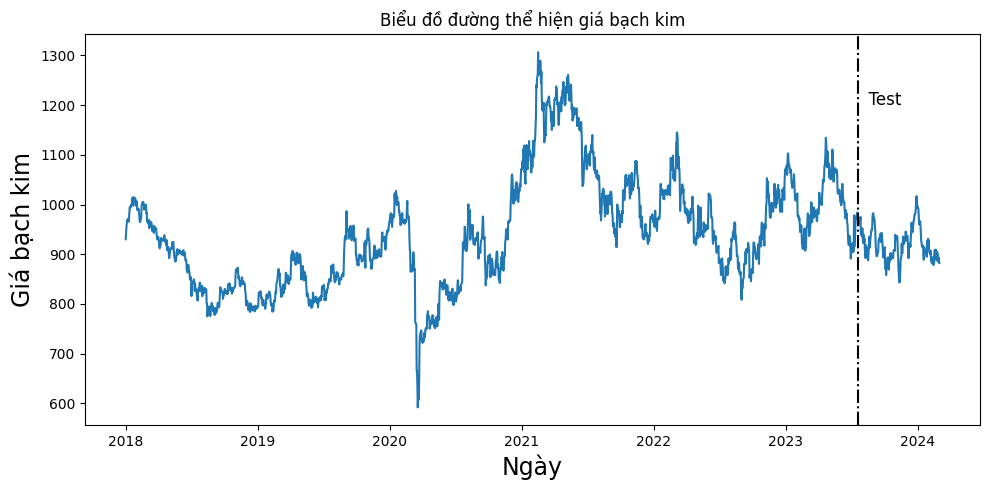

In [32]:
x_plot = pd.to_datetime(df_platium.ds)
y_plot = df_platium.y.values

x_value = x_plot[2026]

fig = plt.figure(figsize=(10, 5))
fig.tight_layout()

plt.plot(x_plot, y_plot)
plt.title('Biểu đồ đường thể hiện giá bạch kim')
plt.xlabel('Ngày', fontsize=17)
plt.ylabel('Giá bạch kim', fontsize=17)

plt.axvline(x_value, color='black', linestyle='-.')
plt.text(x_value, 1200, '  Test', fontsize=12)

plt.tight_layout()
plt.show()
plt.close()

##### Dùng N-hits để dự đoán giá bạch kim

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type             | Params
--------------------------------------------------
0 | loss         | DistributionLoss | 5     
1 | padder_train | ConstantPad1d    | 0     
2 | scaler       | TemporalNorm     | 0     
3 | blocks       | ModuleList       | 4.4 M 
--------------------------------------------------
4.4 M     Trainable params
5         Non-trainable params
4.4 M     Total params
17.574    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=2000` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


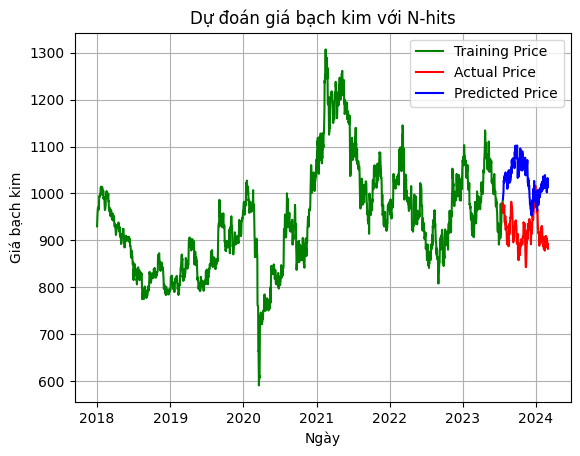

In [33]:
train_df = df_platium.iloc[:2026].reset_index(drop=True)
test_df = df_platium.iloc[2026:].reset_index(drop=True)

# Tạo model
model = NHITS(
    h=len(test_df),
    input_size=(len(test_df) * 2),
    loss=DistributionLoss(distribution='StudentT', level=[80, 90], return_params=True),
    stat_exog_list=[],
    futr_exog_list=[],
    n_freq_downsample=[2, 1, 1],
    scaler_type='robust',
    max_steps=2000,
    inference_windows_batch_size=32,
    learning_rate=1e-4
)

# Huấn luyện và dự đoán
fcst = NeuralForecast(models=[model], freq='D')
fcst.fit(df=train_df)
forecasts = fcst.predict(futr_df=test_df)

# Plotting
Y_hat_df = forecasts.reset_index(drop=False).drop(columns=['unique_id', 'ds'])
plot_df = pd.concat([test_df, Y_hat_df], axis=1)
plot_df = pd.concat([train_df, plot_df])

plot_df = plot_df[plot_df.unique_id=='TAR'].drop('unique_id', axis=1)
plt.plot(train_df['ds'], train_df['y'], color='green', label='Training Price')
plt.plot(test_df['ds'], test_df['y'], c='red', label='Actual Price')
plt.plot(plot_df['ds'], plot_df['NHITS'], c='blue', label='Predicted Price')
plt.xlabel('Ngày')
plt.ylabel('Giá bạch kim')
plt.title('Dự đoán giá bạch kim với N-hits')
plt.legend()
plt.grid()
plt.show()


##### Đánh giá mô hình

In [34]:
# Đánh giá mô hình với dữ liệu giá bạch kim
actual_platium = test_df['y'].values
predict_platium = Y_hat_df['NHITS'].values

rmse_platium = np.sqrt(mean_squared_error(actual_platium, predict_platium))
mape_platium = np.mean(np.abs((actual_platium - predict_platium) / actual_platium)) * 100
mae_platium = mean_absolute_error(actual_platium, predict_platium)

print(f'RMSE: {rmse_platium}')
print(f'MAPE: {mape_platium}%')
print(f'MAE: {mae_platium}')

RMSE: 121.93108896146333
MAPE: 12.079985912948871%
MAE: 109.72096250675126


#### 1.1 Tỉ lệ train 8:2

##### Vẽ biểu đồ

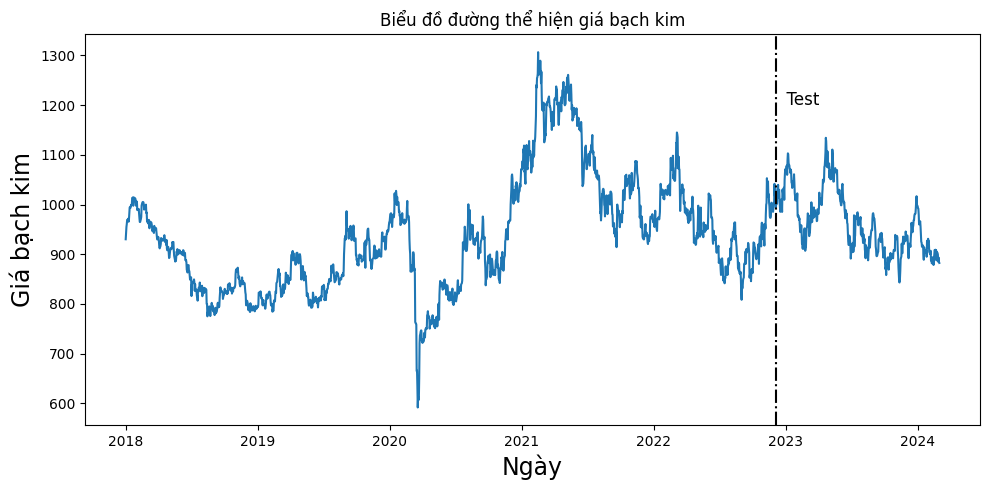

In [35]:
x_plot = pd.to_datetime(df_platium.ds)
y_plot = df_platium.y.values

x_value = x_plot[1800]

fig = plt.figure(figsize=(10, 5))
fig.tight_layout()

plt.plot(x_plot, y_plot)
plt.title('Biểu đồ đường thể hiện giá bạch kim')
plt.xlabel('Ngày', fontsize=17)
plt.ylabel('Giá bạch kim', fontsize=17)

plt.axvline(x_value, color='black', linestyle='-.')
plt.text(x_value, 1200, '  Test', fontsize=12)

plt.tight_layout()
plt.show()
plt.close()

##### Dùng N-hits để dự đoán giá bạch kim

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type             | Params
--------------------------------------------------
0 | loss         | DistributionLoss | 5     
1 | padder_train | ConstantPad1d    | 0     
2 | scaler       | TemporalNorm     | 0     
3 | blocks       | ModuleList       | 6.4 M 
--------------------------------------------------
6.4 M     Trainable params
5         Non-trainable params
6.4 M     Total params
25.686    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=2000` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


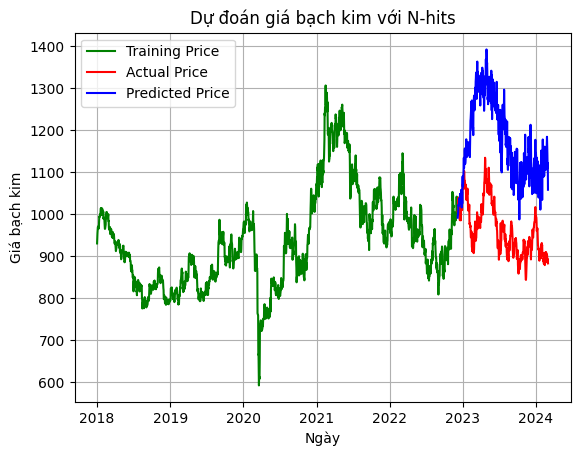

In [36]:
train_df = df_platium.iloc[:1800].reset_index(drop=True)
test_df = df_platium.iloc[1800:].reset_index(drop=True)

# Khai báo model
model = NHITS(
    h=len(test_df),
    input_size=(len(test_df) * 2),
    loss=DistributionLoss(distribution='StudentT', level=[80, 90], return_params=True),
    stat_exog_list=[],
    futr_exog_list=[],
    n_freq_downsample=[2, 1, 1],
    scaler_type='robust',
    max_steps=2000,
    inference_windows_batch_size=32,
    learning_rate=1e-4
)

# Huấn luyện và dự đoán
fcst = NeuralForecast(models=[model], freq='D')
fcst.fit(df=train_df)
forecasts = fcst.predict(futr_df=test_df)

# Plotting
Y_hat_df = forecasts.reset_index(drop=False).drop(columns=['unique_id', 'ds'])
plot_df = pd.concat([test_df, Y_hat_df], axis=1)
plot_df = pd.concat([train_df, plot_df])

plot_df = plot_df[plot_df.unique_id=='TAR'].drop('unique_id', axis=1)
plt.plot(train_df['ds'], train_df['y'], color='green', label='Training Price')
plt.plot(test_df['ds'], test_df['y'], c='red', label='Actual Price')
plt.plot(plot_df['ds'], plot_df['NHITS'], c='blue', label='Predicted Price')

plt.xlabel('Ngày')
plt.ylabel('Giá bạch kim')
plt.title('Dự đoán giá bạch kim với N-hits')
plt.legend()
plt.grid()
plt.show()


##### Đánh giá mô hình

In [37]:
# Đánh giá mô hình với dữ liệu giá bạch kim
actual_platium = test_df['y'].values
predict_platium = Y_hat_df['NHITS'].values

rmse_platium = np.sqrt(mean_squared_error(actual_platium, predict_platium))
mape_platium = np.mean(np.abs((actual_platium - predict_platium) / actual_platium)) * 100
mae_platium = mean_absolute_error(actual_platium, predict_platium)

print(f'RMSE: {rmse_platium}')
print(f'MAPE: {mape_platium}%')
print(f'MAE: {mae_platium}')

RMSE: 226.0126901569684
MAPE: 21.869234113308583%
MAE: 208.669484533274


#### 1.1 Tỉ lệ train 7:3

##### Vẽ biểu đồ

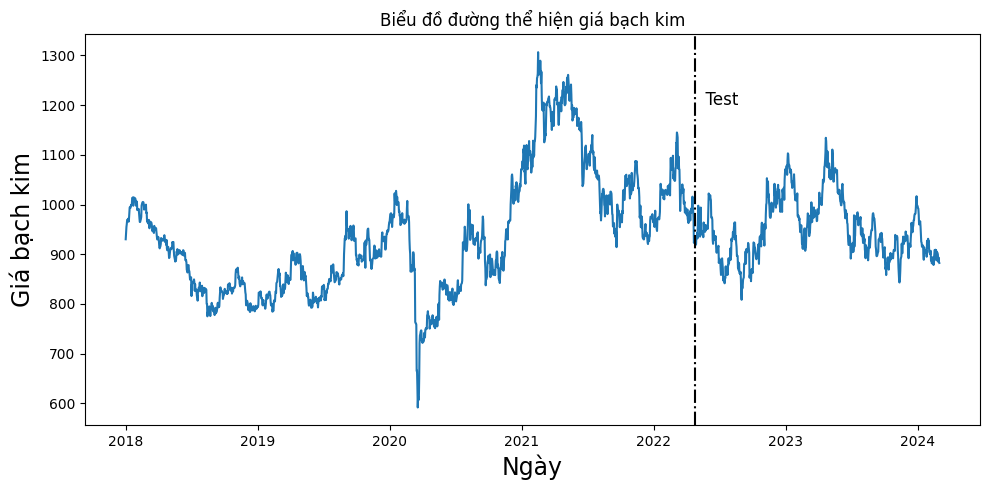

In [38]:
x_plot = pd.to_datetime(df_platium.ds)
y_plot = df_platium.y.values

x_value = x_plot[1576]

fig = plt.figure(figsize=(10, 5))
fig.tight_layout()

plt.plot(x_plot, y_plot)
plt.title('Biểu đồ đường thể hiện giá bạch kim')
plt.xlabel('Ngày', fontsize=17)
plt.ylabel('Giá bạch kim', fontsize=17)

plt.axvline(x_value, color='black', linestyle='-.')
plt.text(x_value, 1200, '  Test', fontsize=12)

plt.tight_layout()
plt.show()
plt.close()

##### Dùng N-hits để dự đoán giá bạch kim

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type             | Params
--------------------------------------------------
0 | loss         | DistributionLoss | 5     
1 | padder_train | ConstantPad1d    | 0     
2 | scaler       | TemporalNorm     | 0     
3 | blocks       | ModuleList       | 8.4 M 
--------------------------------------------------
8.4 M     Trainable params
5         Non-trainable params
8.4 M     Total params
33.726    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=2000` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


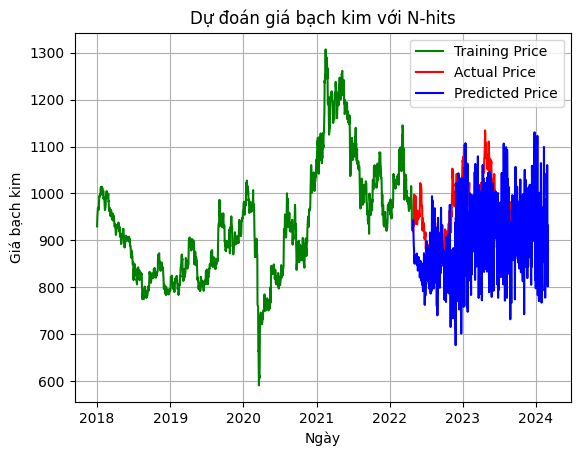

In [39]:
train_df = df_platium.iloc[:1576].reset_index(drop=True)
test_df = df_platium.iloc[1576:].reset_index(drop=True)

# Tạo model
model = NHITS(
    h=len(test_df),
    input_size=(len(test_df) * 2),
    loss=DistributionLoss(distribution='StudentT', level=[80, 90], return_params=True),
    stat_exog_list=[],
    futr_exog_list=[],
    n_freq_downsample=[2, 1, 1],
    scaler_type='robust',
    max_steps=2000,
    inference_windows_batch_size=32,
    learning_rate=1e-4
)

# Huấn luyện và dự đoán
fcst = NeuralForecast(models=[model], freq='D')
fcst.fit(df=train_df)
forecasts = fcst.predict(futr_df=test_df)

# Plotting
Y_hat_df = forecasts.reset_index(drop=False).drop(columns=['unique_id', 'ds'])
plot_df = pd.concat([test_df, Y_hat_df], axis=1)
plot_df = pd.concat([train_df, plot_df])

plot_df = plot_df[plot_df.unique_id=='TAR'].drop('unique_id', axis=1)
plt.plot(train_df['ds'], train_df['y'], color='green', label='Training Price')
plt.plot(test_df['ds'], test_df['y'], c='red', label='Actual Price')
plt.plot(plot_df['ds'], plot_df['NHITS'], c='blue', label='Predicted Price')
plt.xlabel('Ngày')
plt.ylabel('Giá bạch kim')
plt.title('Dự đoán giá bạch kim với N-hits')
plt.legend()
plt.grid()
plt.show()


##### Đánh giá mô hình

In [40]:
# Đánh giá mô hình với dữ liệu giá bạch kim
actual_platium = test_df['y'].values
predict_platium = Y_hat_df['NHITS'].values

rmse_platium = np.sqrt(mean_squared_error(actual_platium, predict_platium))
mape_platium = np.mean(np.abs((actual_platium - predict_platium) / actual_platium)) * 100
mae_platium = mean_absolute_error(actual_platium, predict_platium)

print(f'RMSE: {rmse_platium}')
print(f'MAPE: {mape_platium}%')
print(f'MAE: {mae_platium}')

RMSE: 104.80274473851863
MAPE: 8.485117742016119%
MAE: 82.25961568362266
